## <font color=darkblue> Introduction to Recurrent Neural Networks</font>


In this notebook, we provide an **overview of recurrent neural networks** (and an introdution to Long Short Term Memory networks), which are the first architectures specifically designed to deal with time dependent data.

In this session we set the focus on the most simple networks for data streams to discuss backpropagation  and comparison to other historical statistical models.  This motivates **additional sessions on more complex networks for sequential data** with more involved technicalities: LSTM, Transformers...

### <font color=darkred> Bibliography & additional ressources </font>

-  [1] Probabilistic machine learning: an introduction, Kevin P. Murphy, 2022, https://probml.github.io/pml-book/book1.html
``Full book online with all basics on machine learning. Not state-of-the-art but very good introduction``
- [2] Deep learning course, Ms. Sc. Institut Polytechnique de Paris, https://github.com/m2dsupsdlclass/lectures-labs
- [3] Inference in hidden Markov models, Cappé, O. et al., 2005, https://link.springer.com/book/10.1007/0-387-28982-8
``Classical book on hidden Markov models with a theoretical and practctical overview``
- [4] Long short-term memory, Hochreiter S. and Schmidhuber J., 1993,   http://www.bioinf.jku.at/publications/older/2604.pdf
- [5] Nonlinear Time Series : Theory, Methods and Applications with R
Examples, Douc, R., Moulines, É., and Stoffer, D. (2013), Chapman & Hall
- [6] Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation, Cho, Kyunghyun; van Merrienboer, Bart; Bahdanau, DZmitry; Bougares, Fethi; Schwenk, Holger; Bengio, Yoshua (2014). ([pdf](https://aclanthology.org/D14-1179.pdf))

## <font color=darkred> Introduction</font>

When applying machine learning to sequences, we use an input to predict an output sequence $Y_{0:T}$. Designing **generative models based on hidden states** with their own dynamics allows to propose rich statistical models for the output sequence.


There are numerous statistical models to describe $Y_{0:T}$.





- Statistical models for time series such as autoregressive models: **Autoregressive Moving Average** (ARMA) models, **Autoregressive Integrated Moving Average** (ARIMA) models...

- Models with latent data to propose more complex generative mechanisms depending on unobserved sequences: mixture models, **Hidden Markov Models** (HMM).
- Models based on deep architecures: **Recurrent Neural networks** (RNN)...

For instance, in ARIMA models, $Y_t$  is regressed on its values and  the regression error is a linear combination of past error terms:

$$
Y_t = \sum_{i=1}^p \alpha_i Y_{t-i} + \varepsilon_t + \sum_{j=1}^q \theta_j \varepsilon_j\,,
$$
where $(\epsilon_s)_{s\geq 0}$ are i.i.d. Gaussian random variables.

`Random walks`, `random walks with drift` or `exponential smoothing` models are specific ARIMA models. See an implementation in the [`statsmodels package`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html).

The **AR Autoregression** models the relationship between an observation and some number of lagged observations.

The **Integrated** part differenciates raw observations in order to make the time series stationary.

The **Moving Average** models the dependency
between an observation and a residual error from a moving average model.


**Some limitations of ARIMA models**

- Difficult to predict regime shifts and poor performance  for long term forecasts.
- Choice of the hyperparameters not easy in many practical situations.

We propose in this notebook to present in detail **hidden Markov models** an **recurrent neural networks**.

## <font color=darkred> Part *I* : Preamble on hidden Markov models (HMM)</font>

Hidden Markov models are defined by a bivariate Markov chain $\{(X_k,Y_k)\}_{k\in\mathbb{N}}$ on $\mathsf{X}\times\mathsf{Y}$ where $(\mathsf{X},\mathcal{X})$ and $(\mathsf{Y},\mathcal{Y})$ are two measurable spaces, and where the transition is defined as follows.


\begin{align*}
\mathrm{Conditionally \; on \;} (X_{0:k-1},Y_{0:k-1}), \; X_k \sim Q_{k,\theta}(X_{k-1},\cdot),\\
\mathrm{Conditionally \; on \; } (X_k,X_{0:k-1},Y_{0:k-1}), \; Y_k \sim G_{k,\theta}(X_k,\cdot),
\end{align*}


with $Q_{k,\theta}$  a Markov kernel on $(\mathsf{X},\mathcal{X})$ and $G_{k,\theta}$  a Markov kernel on $(\mathsf{X},\mathcal{Y})$.


In such a model, **only $Y_{0:T}$ are observed and inference must be driven on the basis of $Y_{1:n}$ only**.





A graphical model of a hidden Markov model with observations $(Y_t)_{t\geq 0}$ and latent states $(X_t)_{t\geq 0}$.
![](https://i.stack.imgur.com/TgxG0.png)

The states **$X_{0:T}$ are not observed and have a Markovian dynamics** i.e. the law of $X_t$ given the past depends on $X_{t-1}$ only. However, **the observations are not Markovian** which means that a complex behavior can be described for the observations using a simple Markov chain for the latent states. See [3] for much more details on the statistical properties of such models.

In a fully dominated model, we assume that $Q_{k,\theta}(x,\mathrm{d} x')=q_{k,\theta}(x,x') \lambda(\mathrm{d} x')$ and $G_{k,\theta}(x,\mathrm{d} y)=g_{k,\theta}(x,y) \nu(\mathrm{d} y)$ where $\lambda$ and $\nu$ are $\sigma$-finite dominating measures on $(\mathsf{X},\mathcal{X})$, and $(\mathsf{Y},\mathcal{Y})$ respectively.




A classical example is given by linear and Gaussian HMM where:
\begin{align*}
X_k &= AX_{k-1} +\varepsilon_k\,,\\
Y_k &= BX_k + \eta_k\,,
\end{align*}
with  $\{(\varepsilon_k,\eta_k)\}_{k\geq 0}$ i.i.d. independent Gaussian random noise with variances $Q$ and $R$.

Statistical inference for non-linear state-space models involves the computation of the **posterior distributions of the state $Z_{m:n}$ given $Y_{0:n}$**, denoted by $\phi_{m:n|n}$.


$$
\mathbb{E}\left[f(Z_{m:n})\middle|  Y_{0:n}\right] = \phi_{m:n|n}(f)\,.
$$

- **Joint smoothing**: $\phi_{0:n|n}$, $n\geqslant 0$.

- **Marginal smoothing**: $\phi_{k|n}=\phi_{k:k|n}$, $0\leqslant k\leqslant n$.

- **Prediction**: $\phi_{n+1|n}=\phi_{n+1:n+1|n}$, $n\geqslant 0$.

- **Filtering**: $\phi_n = \phi_{n:n|n}$, $n\geqslant 0$.


These distributions can be computed in closed forms in **very few cases**:
``Linear Gaussian models`` and ``discrete-valued HMM``.


**Kalman filter**
In the linear and Gaussian case above, the law of $X_k$ given $Y_{0:k}$ is Gaussian and its mean $\hat x_{k|k}$ and variance $P_{k|k}$ are updated as follows.

- ``Prediction``:
\begin{align*}
\hat x_{k|k-1} &= A\hat x_{k-1|k-1}\,,\\
P_{k|k-1} &= AP_{k-1|k-1}A^\top + Q\,.
\end{align*}



- ``Update``:
\begin{align*}
\hat y_k & = y_k - B\hat x_{k|k-1}\,,\\
S_k &= B P_{k|k-1} B^\top + R\,,\\
K_k &= P_{k|k-1} B^\top S^{-1}_k\,,\\
\hat x_{k|k} &= \hat x_{k|k-1} + K_k\hat y_k\,,\\
P_{k|k} &= (I-K_kB)P_{k|k-1}\,.
\end{align*}

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Basic_concept_of_Kalman_filtering.svg/1280px-Basic_concept_of_Kalman_filtering.svg.png
)

### Inference for HMM

- **Stochastic gradient**

The complete data log-likelihood is written as
\begin{align*}
\log p_{\theta}(Z_{0:n},Y_{0:n}) &= \log \xi_{\theta}(Z_0) + \sum_{k=1}^n \log q_{\theta,k}(Z_{k-1},Z_k)\\
& \hspace{3cm}+ \sum_{k=0}^n \log g_{\theta,k}(Z_k,Y_k)\,,
\end{align*}
where $\xi_{\theta}$ is the density of the initial state.







By Fisher's identity (see [5]), up to the initial state,
\begin{align*}
\nabla_{\theta} \ell_n(\theta) &= \nabla_{\theta}\log p_{\theta}(Y_{0:n})\,,\\ %= \sum_{k=1}^n \int \nabla_{\theta} \log m_{\theta}(z_{k-1},z_k)\phi^{\theta}_{k-1:k|n}(\rmd z_{k-1:k}) \\
 %&\hspace{4cm}+ \sum_{k=0}^n \int \nabla_{\theta} \log g_{\theta}(z_{k},Y_k)\phi^{\theta}_{k|n}(\rmd z_{k})\,,\\
&=\sum_{k=1}^n\mathbb{E}_{\theta}\left[\nabla_{\theta} \log q_{\theta}(Z_{k-1},Z_k)\middle|Y_{0:n}\right] \\
&\hspace{3cm}+ \sum_{k=0}^n\mathbb{E}_{\theta}\left[\nabla_{\theta} \log g_{\theta}(Z_{k},Y_k)\middle|Y_{0:n}\right]\,.
\end{align*}
The computation of $\nabla_{\theta} \ell_n(\theta)$ requires expectations under $\phi^{\theta}_{k-1:k|n}$ and $\phi^{\theta}_{k|n}$.

Step-size sequence $\{\gamma_k\}_{k\ge 0}$ such that $\sum_k \gamma_k=+\infty$ and $\sum_k \gamma^2_k<+\infty$.

**Gradient approach** to produce a sequence of parameter estimates $\{\theta_p\}_{p\ge 0}$,
$$
\theta_{p+1} = \theta_p + \gamma_{p+1}\nabla_{\theta=\theta_p}\ell_n(\theta)\,.
$$


``Practical choice``: $\gamma_k = ck^{-\alpha}$, $0.5<\alpha<1$.


- **Expectation Maximization algorithm**

The complete data log-likelihood is written as
$$
\log p_{\theta}(Z_{0:n},Y_{0:n}) =  \sum_{k=1}^n \log q_{\theta,k}(Z_{k-1},Z_k) + \sum_{k=0}^n \log g_{\theta,k}(Z_k,Y_k)\,.
$$

Let $\mathcal{Q}(\theta;\theta')$ be the ``intermediate quantity``
$$
\mathcal{Q}(\theta;\theta') = \mathbb{E}_{\theta'}\left[\log p_{\theta}(Z_{0:n},Y_{0:n})\middle | Y_{0:n}\right]\,.
$$

``Iterative procedure`` which produces a sequence $\{\theta_p\}_{p\geqslant 0}$ of parameter estimates.

$$
\mathcal{Q}(\theta;\theta_p) = \sum_{k=1}^n\phi^{\theta_p}_{k-1:k|n}\left[\log q_{\theta,k-1}\right] + \sum_{k=0}^n\phi^{\theta_p}_{k-1:k|n}\left[\log g_{\theta,k}(\cdot,Y_k)\right]\,.
$$

Each iteration decomposed into

**E-step**: compute $\theta\mapsto \mathcal{Q}(\theta_p,\theta)$.

**M-step**: compute $\theta_{p+1}= \mathrm{argmax}_{\theta} \mathcal{Q}(\theta_p,\theta)$.


### Limitations of HMM

- Parameter estimation requires the **computation of expectations** which are estimated using **Monte Carlo methods** in most cases. This is often cumbersome in high dimensional settings or for long records of observations. Efficient methods in high dimension are very technical.

- The assumption that the **latent state is Markovian can be too strong** to deal with some real data.

- These models can be modified to take into account **seasonality and trends** but at the cost of additional technicalities.

## <font color=darkred> Part *II* : Recurrent Neural Networks </font>

### Rationale

We want to build a neural network specifically designed to process an input sequence $x_{1:T} = (x_1, ..., x_T)$ to predict an output sequence. Recurrent neural networks (RNNs) are designed to model dependencies for sequences of arbitrary length.

Consider a **supervised learning** task which aims to predict  $y_{1:T} = (y_1, ..., y_T )$ using the input $x_{1:T}$. A simple RNN layer writes, for $1\leq t \leq T$,
\begin{align*}
h_t &= \phi_h(W_hh_{t−1} + W_xx_t + b_h)\,,\\
y_t &= \phi_y(W_yh_t + b_y)\,.
\end{align*}
In this case, the latent states are the $(h_t)_{t\geq 0}$.



The unknown parameters are $\theta = \{W_h, W_x, W_y, b_h, b_y\}$, and $\phi_h$ and $\phi_y$ are the
 activation functions.

Usually, the model is initialized with $h_0 = 0$.
 
 In a regression framework, given sequences of inputs $x^i_{0:T}$ and outputs $y^{*,i}_{0:T}$, training a RNN usually  boils down to solving
$$\mathrm{argmin}_{\theta \in \mathbb{R}^d} \,\left\{\ell_n(\theta)=\frac{1}{nT} \sum_{i=1}^n \sum_{t=1}^T \|y^i_t-y_t^{*,i}\|_2^2 + \lambda \|\theta\|_2^2\right\}\,,
$$
 with $\lambda>0$ and $y^i_t$ is the prediction produced at time $t$ by the RNN.

A graphical model of a RNN.
![](https://www.researchgate.net/profile/Yassin-Khalifa-3/publication/346853926/figure/fig2/AS:1007113883119616@1617126069530/A-simple-RNN-with-a-single-hidden-layer-At-each-time-step-output-is-produced-through_W640.jpg)

RNNs use:

- distributed hidden state that allow **to store  information
about the past efficiently**;

- non-linear dynamics to update hidden states.

**Recurrent neural networks are
deterministic**.

### Implementation in Torch

A RNN layer is built using ``nn.RNN`` An RNN takes in a number of parameters:

``torch.nn.RNN`` has two inputs.

- ``input`` is the sequence which given to the RNN and is of size ``(seq_len, batch, input_size)``. If ``batch_first=True``, the input size is ``(batch, seq_len, input_size)``.

- ``h_0`` is the initial hidden state of the RNN. It is of the size ``(num_layers, batch, input_size)`` where ``num_layers`` is the number of stacked layers.

``torch.nn.RNN`` has two outputs.

- ``out`` is the output of the RNN from all timesteps from the last RNN layer and is of the size ``(seq_len, batch, hidden_size)``. If ``batch_first=True``, the output size is ``(batch, seq_len, hidden_size)``.

- ``h_n`` is the hidden value from the last time-step of all RNN layers. It is of the size ``(num_layers, batch, hidden_size)``.

For more detailed information, check the [torch documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN).

### Toy data sets to manipulate torch.nn

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
!wget https://gitlab.com/jules.lefrancq-lumiere/ateliers_algos/-/raw/main/ateliers_algos_rnn/toy_example_data.csv
inputs_raw = np.loadtxt('toy_example_data.csv', dtype=np.float32, delimiter=',')
inputs_raw.shape

--2023-07-25 13:45:36--  https://gitlab.com/jules.lefrancq-lumiere/ateliers_algos/-/raw/main/ateliers_algos_rnn/toy_example_data.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257896 (252K) [text/plain]
Saving to: ‘toy_example_data.csv.2’

toy_example_data.cs 100%[===================>] 251.85K  --.-KB/s    in 0.02s   

2023-07-25 13:45:37 (11.5 MB/s) - ‘toy_example_data.csv.2’ saved [257896/257896]



(1000, 10)

In [ ]:
## Let us reshape the inputs so that their dimensions march the following required dimensions :
inputs = inputs_raw.reshape(-1,10,2)
print(f"Input size : (batch, seq_len, input_size): {inputs.shape}")
inputs = torch.from_numpy(inputs)

Input size : (batch, seq_len, input_size): (500, 10, 2)


**One-layer RNN**

In [ ]:
input_size = 2
hidden_size = 8
num_layers = 1

# Initialize the RNN.
rnn = nn.RNN(
    input_size=input_size,
    hidden_size = hidden_size,
    num_layers = num_layers,
    batch_first=True
)
out, h_n = rnn(inputs)

print(f"Shape of the output (batch, seq_len, num_directions * hidden_size): {out.shape}")
print(f"Shape of the hidden value (num_layers, batch, input_size): {h_n.shape}")

Shape of the output (batch, seq_len, num_directions * hidden_size): torch.Size([500, 10, 8])
Shape of the hidden value (num_layers, batch, input_size): torch.Size([1, 500, 8])


**Multi-layer RNN**




``To be completed
 Buid a three-layer LSTM using nn.RNN``


### Key ingredients of backpropagation

The loss function is of the form
$$
\theta\mapsto\sum_{t=1}^T \mathcal{L}_\theta(y_t)\,,
$$
where for $1\leq t \leq T$,
\begin{align*}
h_t &= \phi_h(W_hh_{t−1} + W_xx_t + b_h)\,,\\
y_t &= \phi_y(W_yh_t + b_y)\,,
\end{align*}
And $h_0 = 0$.

• **Derivative of $\mathcal{L}_\theta(y_t)$ w.r.t. $W_y$ and $b_y$**:

\begin{align*}
\frac{\partial \mathcal{L}_\theta(y_t)}{\partial W_y} &= \frac{\partial \mathcal{L}_\theta(y_t)}{\partial y_t} \frac{\partial y_t}{\partial W_y}\,,\\
\frac{\partial \mathcal{L}_\theta(y_t)}{\partial b_y} &= \frac{\partial \mathcal{L}_\theta(y_t)}{\partial y_t} \frac{\partial y_t}{\partial b_y}\,.
\end{align*}


• **Derivative of $\mathcal{L}_\theta(y_t)$ w.r.t. $W_x$ and $b_h$**:

\begin{align*}
\frac{\partial \mathcal{L}_\theta(y_t)}{\partial W_x} &= \frac{\partial \mathcal{L}_\theta(y_t)}{\partial y_t} \frac{\partial y_t}{\partial h_t} \frac{\partial h_t}{\partial W_x}\,,\\
\frac{\partial \mathcal{L}_\theta(y_t)}{\partial b_h} &= \frac{\partial \mathcal{L}_\theta(y_t)}{\partial y_t} \frac{\partial y_t}{\partial h_t} \frac{\partial h_t}{\partial b_h}\,.
\end{align*}




``To be completed
Use the chain rule to write the derivatives`` $\frac{\partial h_t}{\partial W_x}$



• **Derivative of $\mathcal{L}_\theta(y_t)$ w.r.t. $W_h$**:

$$
\frac{\partial \mathcal{L}_\theta(y_t)}{\partial W_h} = \frac{\partial \mathcal{L}_\theta(y_t)}{\partial h_t} \frac{\partial h_t}{\partial W_h} =  \frac{\partial \mathcal{L}_\theta(y_t)}{\partial y_t}\frac{\partial y_t}{\partial h_t} \frac{\partial h_t}{\partial W_h}\,,
$$
where
$$
\frac{\partial h_t}{\partial W_h} = \frac{\partial h_t}{\partial W_h} + \frac{\partial h_t}{\partial h_{t-1}}\frac{\partial h_{t-1}}{\partial W_h}\,.
$$

### Gradient vanishing and tricks

Simple RNNs suffer from gradient vanishing or gradient explosion issues. Note that
$$
\frac{\partial h_t}{\partial W_h} = \sum_{\tau=1}^{t}\left(\prod_{\ell=\tau}^{t-1} \frac{\partial h_{\ell+1}}{h_{\ell}}\right)\frac{\partial h_\tau}{\partial W_h}
$$
and
$$
\frac{\partial h_{\ell+1}}{h_{\ell}} = \phi'_h(W_hh_{\ell} + W_xx_{\ell+1} + b_h)\odot W_h\,,
$$
where $\phi'_h(W_hh_{\ell} + W_xx_{\ell+1} + b_h)$ contains element-wise derivatives and $\odot$ is the elment-wise product.

The term $\prod_{\ell=\tau}^{t-1} \frac{\partial h_{\ell+1}}{h_{\ell}}$ can vanish or explode when $t − \tau$ is large, depending on the eigenvalues of $W_h$.


**Some practical tricks**
- **Gradient clipping** is often used to prevent the gradient from explosion.Let $\gamma$ and $\eta$ be fixed hyperparameters.  Then, gradient clipping simply replaces the gradient $\nabla_\theta \mathcal{L}(y_t)$ by
$$
\widetilde \nabla_\theta \mathcal{L}(y_t) = \mathbb{1}_{\|\nabla_\theta \mathcal{L}(y_t)\|\leq \eta}\nabla_\theta \mathcal{L}(y_t) + \mathbb{1}_{\|\nabla_\theta \mathcal{L}(y_t)\|> \eta} \frac{\gamma}{\|\nabla_\theta \mathcal{L}(y_t)\|}\nabla_\theta \mathcal{L}(y_t)\,.
$$
Then, the maximum norm of the gradient is bounded, however this introduces bias in this optimization procedure (and this is the case for all variants of gradient clipping).
- **Truncated backpropagation** sets some maximum number of time steps $n$ along which the error is propagated. This means that we limit the number of factors in the previsous gradient which prevents the gradient from growing exponentially. However, this also prevents an efficient  learning of long-range dependencies.
- Specific constraints such as imposing that **$W_h$ is an orthogonal matrix** improve the gradient issues (although they do not prevent it for long term behavior), since the eigenvalues of an orthogonal matrix have absolute value 1.

## <font color=darkred> Part III : Introduction to LSTM</font>

In practice, even with the few tricks discussed before, RNN cannot model long-term dependencies. Introduced in [4], LSTM aims at overcoming the issues of RNN.

LSTMs also have a chain-like structure, composed of four interacting sublayers.


Writing $z_t = (h_{t-1},x_t)$, the LSTM cell writes:
\begin{align*}
f_t &= \sigma(W_f z_t + b_f)\,, \quad \mathrm{ forget\; gate}\,,\\
i_t &= \sigma(W_i z_t + b_i)\,, \quad \mathrm{ input\; gate}\,,\\
\tilde c_t &= \mathrm{tanh}(W_c z_t + b_c)\,\\
c_t &= f_t c_{t-1}+ i_t \tilde c_t\,,\\
o_t &= \sigma(W_o z_t + b_o)\,\\
h_t &= o_t\mathrm{tanh}( c_t)\,.
\end{align*}

The model is more complex than a simple RNN but the several gates allow to decide **what information is kept or removed in the cell state**. This will be detailed in a session dedicated to LSTM.

A graphical model of a LSTM.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/1280px-Peephole_Long_Short-Term_Memory.svg.png)


**GRU variant**
Many variants have been proposed (and no real theoretical results to foster one variant). The Gated Recurrent Unit, or GRU, introduced by [6] is very popular. It **combines the forget and input gates into a single update gate** and **merges the cell state and hidden state**.

Writing $u_t = (h_{t-1},x_t)$, the GRU cell writes:
\begin{align*}
z_t &= \sigma(W_s u_t + b_s)\,,\\
r_t &= \sigma(W_r u_t + b_r)\,, \\
\tilde h_t &= \mathrm{tanh}(W_h (r_t h_{t-1},x_t)^\top)\,\\
h_t &= (1-z_t)h_{t-1} + z_t \tilde h_t\,.
\end{align*}


![](https://miro.medium.com/v2/resize:fit:1400/0*c3WksH9kuFrQy7rz
)

## <font color=darkred> Part IV.a : Application to time series regression</font>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

In [ ]:
# Download dataset
!wget https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv
df = pd.read_csv('heating_lilles.csv')
df.index = pd.DatetimeIndex(df.datetime) + pd.DateOffset(years=-1)
# Add occupation as prior knowledge of the building
df["occupation"] = df.index.map(lambda date: date.hour > 6 and date.hour < 20 and date.weekday() < 5).astype(int)
# Select heating period
df = df[(df.index < datetime.datetime(2019, 4, 18)) | (df.index >= datetime.datetime(2019, 10, 3))]
# Display the dataframe
df.sample(5)

--2023-07-24 16:26:04--  https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406331 (1.3M) [text/plain]
Saving to: ‘heating_lilles.csv’

heating_lilles.csv  100%[===================>]   1.34M  3.81MB/s    in 0.4s    

2023-07-24 16:26:05 (3.81 MB/s) - ‘heating_lilles.csv’ saved [1406331/1406331]



,datetime,outdoor_temperature_deg_celsius,relative_humidity_per_cent,wind_speed_m_per_s,diffuse_horizontal_radiation_Wh_per_m2,direct_normal_radiation_Wh_per_m2,ZONE+00_+00_+00:Zone Operative Temperature [C](Hourly),heating_J,cooling_J,heating_kWh,cooling_kWh,internal_gains_kWh,infiltration_energy_kWh,ventilation_energy_kWh,inside_conduction_energy_kWh,windows_energy_constant_temperature_kWh,occupation
datetime,,,,,,,,,,,,,,,,,
2019-12-29 02:00:00,2020-12-29 02:00:00,0.06,92.0,1.86,0.0,0.0,14.999458,2.587836e+07,0.0,7.188434,0.0,0.0,-3.544262,-0.500124,-1.413827,-1.730220,0
2019-02-23 16:00:00,2020-02-23 16:00:00,12.71,55.0,1.86,29.8,382.7,16.386927,0.000000e+00,0.0,0.000000,0.0,0.0,-0.714785,0.000000,-6.263439,6.978224,0
2019-04-03 23:00:00,2020-04-03 23:00:00,2.49,94.0,2.41,0.0,0.0,17.111511,0.000000e+00,0.0,0.000000,0.0,0.0,-3.044861,0.000000,2.227964,0.816897,0
2019-11-30 03:00:00,2020-11-30 03:00:00,0.39,98.0,1.38,0.0,0.0,15.127852,0.000000e+00,0.0,0.000000,0.0,0.0,-3.026201,0.000000,4.692561,-1.666359,0
2019-03-01 05:00:00,2020-03-01 05:00:00,7.48,91.0,3.66,0.0,0.0,15.945284,0.000000e+00,0.0,0.000000,0.0,0.0,-1.796331,0.000000,3.165921,-1.369590,0


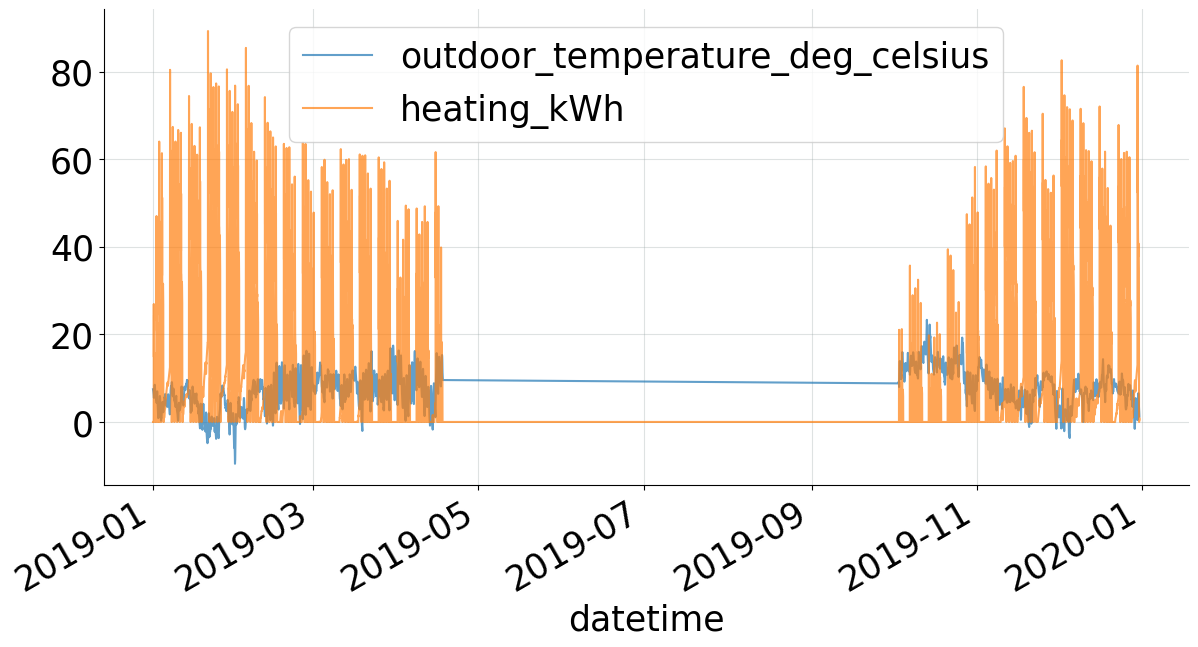

In [ ]:
df.plot(y=["outdoor_temperature_deg_celsius", "heating_kWh"], alpha=0.7);

In [ ]:
# Extract a dataset with a fixed sample size
SAMPLE_SIZE = 24*7*2
# Select inputs and outputs
X = df[["outdoor_temperature_deg_celsius", "occupation"]].values.reshape(-1, SAMPLE_SIZE, 2)
y = df[["heating_kWh"]].values.reshape(-1, SAMPLE_SIZE, 1)
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Normalize
X_max = X_train.reshape(-1, 2).max(0)
y_max = y_train.max()
X_train = X_train / X_max - 0.5
y_train = y_train / y_max - 0.5
X_test = X_test / X_max - 0.5
y_test = y_test / y_max - 0.5
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11, 336, 2), (3, 336, 2), (11, 336, 1), (3, 336, 1))

### Previously, on Atelier Algo: FFN et CNN models

#### Feed Forward network

In [ ]:
model = Sequential([
    tf.keras.Input(shape=(SAMPLE_SIZE, 2)),
    tf.keras.layers.Flatten(),
    
    ######
    ## To be completed: add two dense layers before the output layer
    ## 
    ## 
    #####
    tf.keras.layers.Dense(SAMPLE_SIZE, activation="linear"),
])
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 672)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                16152     
                                                                 
 dense_4 (Dense)             (None, 12)                300       
                                                                 
 dense_5 (Dense)             (None, 336)               4368      
                                                                 
Total params: 20,820
Trainable params: 20,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=16,
    verbose=0,
    validation_data=(X_test, y_test),
    shuffle=True
)
model.evaluate(x=X_test, y=y_test, batch_size=16);

1/1 [==============================] - 0s 25ms/step - loss: 0.0069


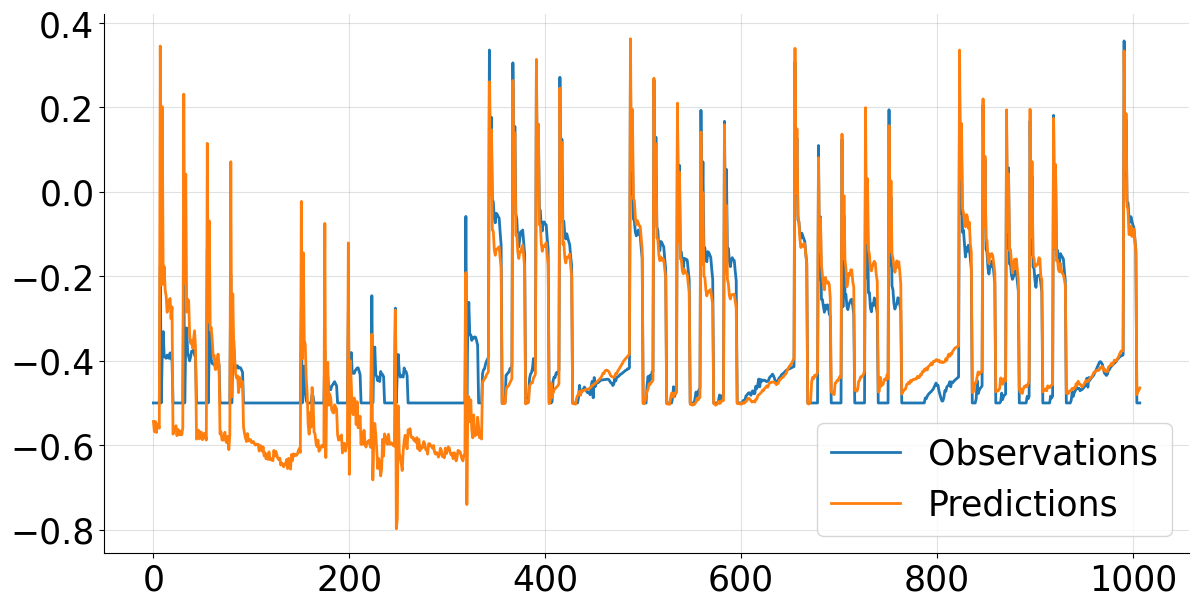

In [ ]:
# Plot predictions over the testing set
y_pred = model.predict(X_test, verbose=0)
plt.plot(y_test.flatten(), lw=2, label="Observations")
plt.plot(y_pred.flatten(), lw=2, label="Predictions")
plt.legend();

#### Convolutional Neural Network

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.Input(shape=(SAMPLE_SIZE, 2)),
    ######
    # To be completed: add two conv1D layers before the output layer
    # 
    # 
    ######
    tf.keras.layers.Conv1D(1, activation='linear', kernel_size=(1)),
])
model_cnn.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 336, 32)           10784     
                                                                 
 conv1d_1 (Conv1D)           (None, 336, 16)           12304     
                                                                 
 conv1d_2 (Conv1D)           (None, 336, 1)            17        
                                                                 
Total params: 23,105
Trainable params: 23,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_cnn.fit(
    x=X_train,
    y=y_train,
    epochs=3000,
    batch_size=16,
    verbose=0,
    validation_data=(X_test, y_test),
    shuffle=True
)
model_cnn.evaluate(x=X_test, y=y_test, batch_size=16);

1/1 [==============================] - 0s 25ms/step - loss: 5.8598e-04


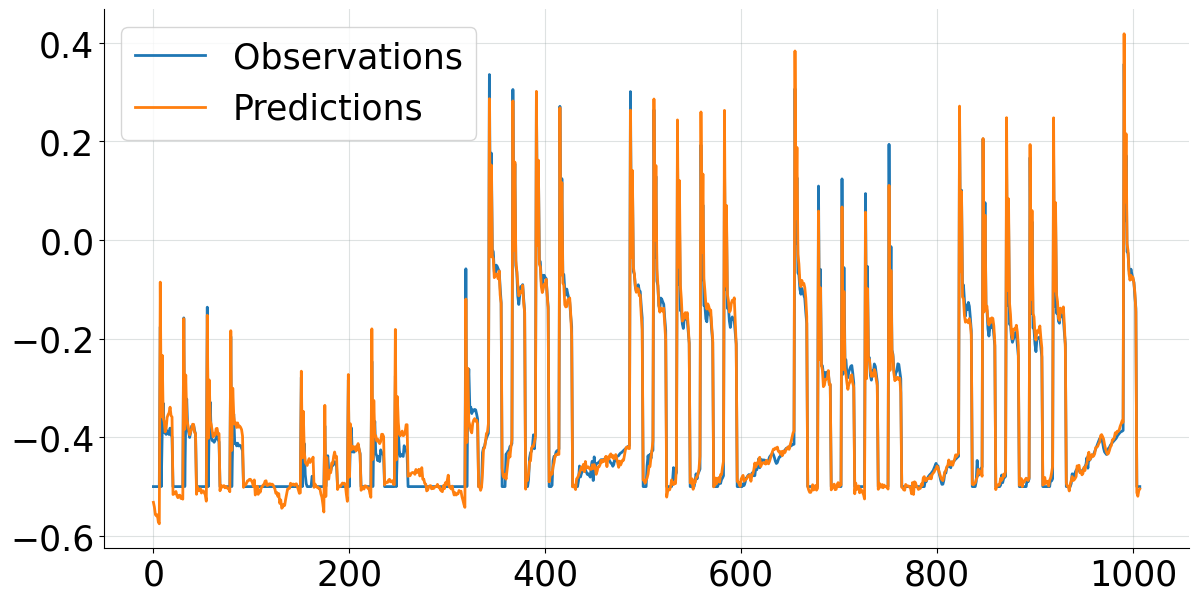

In [ ]:
# Plot predictions over the testing set
y_pred = model_cnn.predict(X_test, verbose=0)
plt.plot(y_test.flatten(), lw=2, label="Observations")
plt.plot(y_pred.flatten(), lw=2, label="Predictions")
plt.legend();

### Recurrent Neural Networks

In [ ]:
model_rnn = tf.keras.Sequential([
    tf.keras.Input(shape=(SAMPLE_SIZE, 2)),
    ######
    # To be completed: add a GRU layer before the output layer
    # 
    ######
    tf.keras.layers.Dense(1),
])
model_rnn.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
)
model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 336, 16)           960       
                                                                 
 dense_9 (Dense)             (None, 336, 1)            17        
                                                                 
Total params: 977
Trainable params: 977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_rnn.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=16,
    verbose=0,
    validation_data=(X_test, y_test),
    shuffle=True
)
model_cnn.evaluate(x=X_test, y=y_test, batch_size=16);

1/1 [==============================] - 0s 25ms/step - loss: 5.8598e-04


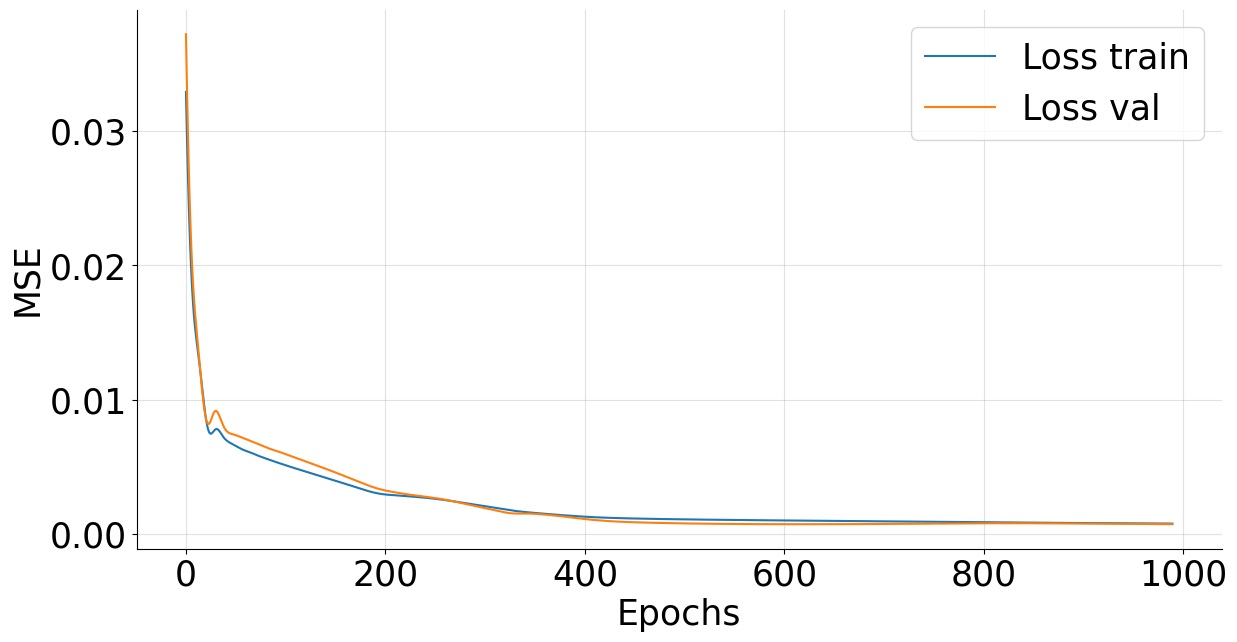

In [ ]:
# Plot loss history
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(history.history["loss"][10:], label="Loss train")
plt.plot(history.history["val_loss"][10:], label="Loss val")
plt.legend();

1/1 [==============================] - 0s 474ms/step


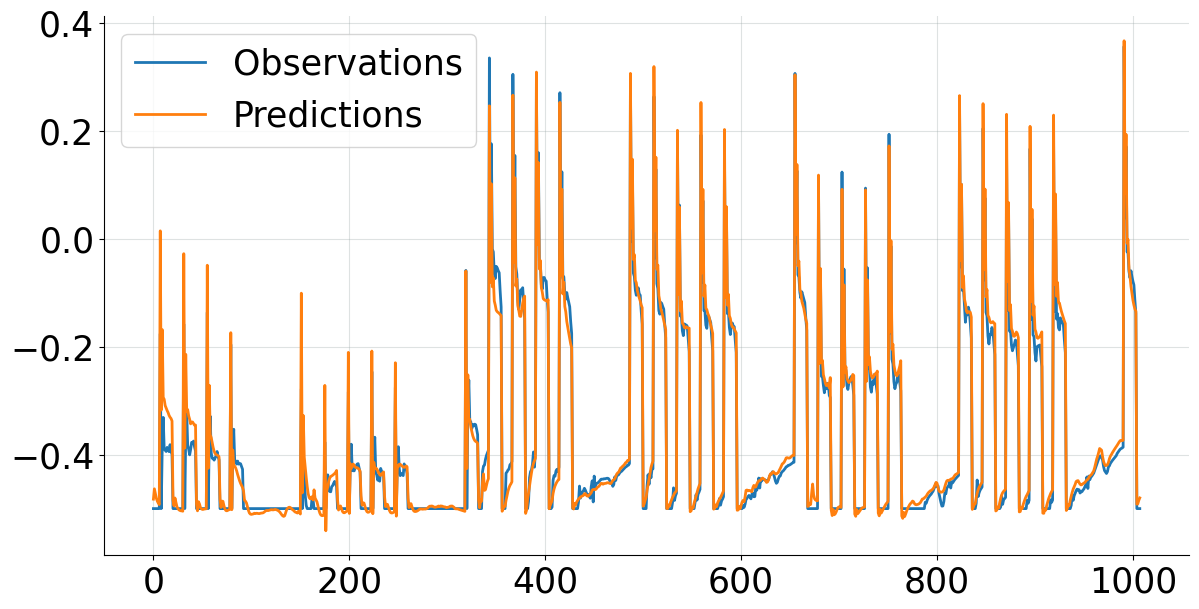

In [ ]:
# Plot predictions over the testing set
y_pred = model_rnn.predict(X_test)
plt.plot(y_test.flatten(), lw=2, label="Observations")
plt.plot(y_pred.flatten(), lw=2, label="Predictions")
plt.legend();

## <font color=darkred> Part IV.b : Application to time series prediction</font>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In the previous example, we used Recurrent Neural networks for a regression task : at a given time step, we inferred one column of the dataframe (``"heating_kWh"``), using two other columns of the dataframe. (``"outdoor_temperature_deg_celsius"`` and ``"occupation"``). In this task, we will focus on building a weather forecasting model. Let us focus on the ``outdoor_temperature_deg_celsius`` column.

In [ ]:
!wget https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv
df = pd.read_csv('heating_lilles.csv')
df.index = pd.DatetimeIndex(df.datetime) + pd.DateOffset(years=-1)
df = df[(df.index >= datetime.datetime(2019, 4, 18)) & (df.index < datetime.datetime(2019, 10, 3))]

--2023-07-27 07:36:35--  https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406331 (1.3M) [text/plain]
Saving to: ‘heating_lilles.csv.3’

heating_lilles.csv. 100%[===================>]   1.34M  --.-KB/s    in 0.009s  

2023-07-27 07:36:35 (154 MB/s) - ‘heating_lilles.csv.3’ saved [1406331/1406331]



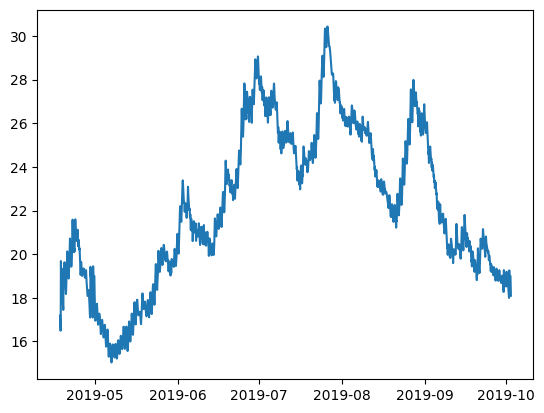

In [ ]:
df_temperature = df["ZONE+00_+00_+00:Zone Operative Temperature [C](Hourly)"]
plt.plot(df_temperature)

In [ ]:
time_series = df_temperature.values
print(time_series.shape)

(4032,)


The goal here is to forecast the weather using the follonwing ML heuristics : given a history of weather temperatures, we want to foresee what the weather will be like in the future. In the following, we will define the following variables :
- We will set ``WINDOW_SIZE`` to be the size of the input data that will be fed to the neural network.  Il we consider our weather data for instance and if ``WINDOW_SIZE`` is set to ``48``, we will feed the neural network with the 48 hours of weather data points to make a prediction.
- We will set the ``SHIFT`` to be the delay between the end of the input and the chosen starting date of the prediction. For instance, for weather data, if we want to predict what the weather will be like in one day from now, we will set the shift to be ``SHIFT = 24``. In our example, we will set ``SHIFT = 6``.
- We will set the ``HORIZON`` to be the total length of the prediction that we want to output. For example, if ``HORIZON = 24``, we will predict the weather will be like for a total duration of 24 hours

In [ ]:
WINDOW_SIZE = 72
SHIFT = 0
HORIZON = 24

In order to train a neural network, we need to sample our time series in sets of labeled data. A common practice is to use rolling time windows. The idea is the following: Finish the explanation

In [ ]:
def get_labelled_window(x, window_size, horizon):
  """
  Splits a window into a data, label pair
  """
  return x[:, :window_size], x[:, -horizon:]

In [ ]:
def make_windows(data, window_size=WINDOW_SIZE, shift = SHIFT, horizon=HORIZON):
  matrix_row_length = window_size + shift+horizon
  window_step = np.arange(window_size+shift+horizon).reshape(1, matrix_row_length)

  matrix_column_length = len(data)-(window_size+horizon+shift-1)
  window_indexes = window_step + np.arange(matrix_column_length).reshape(1, matrix_column_length).T
  windowed_array = data[window_indexes]

  windows, labels = get_labelled_window(windowed_array, window_size = window_size, horizon=horizon)
  return windows, labels

In [ ]:
# Make train/val splits
def make_train_val_splits(data, window_size, shift, horizon, val_split=0.2):
  """
  Splits matching pairs of windows and labels into train and val splits.
  """
  split_size = int(len(data) * (1-val_split))
  data_train = data[:split_size]
  data_val = data[split_size:]
  train_windows, train_labels = make_windows(data_train,
                                             window_size,
                                             shift,
                                             horizon)
  val_windows, val_labels = make_windows(data_val, window_size, shift,horizon)

  return train_windows, train_labels, val_windows, val_labels

In [ ]:
train_windows, train_labels, val_windows, val_labels = make_train_val_splits(
    time_series,
    WINDOW_SIZE,
    SHIFT, HORIZON
    )

In [ ]:
train_max = train_windows.max()
label_max = train_labels.max()
train_windows = train_windows / train_max - 0.5
train_labels = train_labels / label_max - 0.5
val_windows = val_windows / train_max - 0.5
val_labels = val_labels / label_max - 0.5

In [ ]:
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
output = layers.Dense(HORIZON)(x)
model_LSTM = tf.keras.Model(inputs=inputs, outputs=output, name="model_LSTM")

In [ ]:
model_LSTM.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
                   )
model_LSTM.summary()


Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 72)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            102912    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 237,592
Trainable params: 237,592
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
history = model_LSTM.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=64,
            shuffle=True,
            validation_data=(val_windows, val_labels))

Epoch 1/100
49/49 [==============================] - 12s 22ms/step - loss: 0.0081 - val_loss: 0.0012
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 9.7516e-04 - val_loss: 7.7410e-04
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: 7.6149e-04 - val_loss: 5.4498e-04
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: 5.7000e-04 - val_loss: 3.3187e-04
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: 4.3314e-04 - val_loss: 2.5553e-04
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: 3.9579e-04 - val_loss: 2.3103e-04
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: 3.9997e-04 - val_loss: 2.2492e-04
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 3.6980e-04 - val_loss: 2.9368e-04
Epoch 9/100
49/49 [==============================] - 0s 6ms/step - loss: 3.6280e-04 - val_loss: 2.3218e-04
Epoch 10/100
49/49 [=======================

In [ ]:
offset = 6
labels_pred_window = model_LSTM.predict(val_windows)
labels_val_pred = labels_pred_window[:,offset]
labels_val_true = val_labels[:,offset]

52/52 [==============================] - 1s 2ms/step


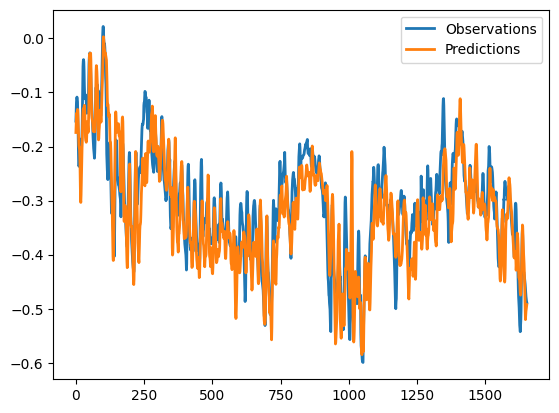

In [ ]:
plt.plot(labels_val_true, lw=2, label="Observations")
plt.plot(labels_val_pred, lw=2, label="Predictions")
plt.legend()

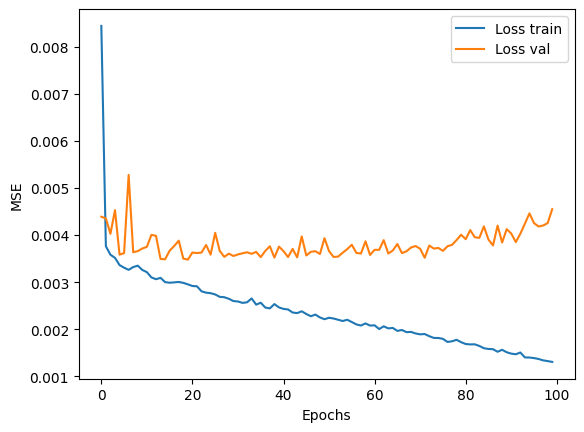

In [ ]:
# Plot loss history
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(history.history["loss"], label="Loss train")
plt.plot(history.history["val_loss"], label="Loss val")
plt.legend();

Trying by chunking the training and val sets.

In [ ]:
def generate_ratios(number_chunks, train_ratio):
  inverse_chunks = 1/number_chunks
  list_ratios = []
  ratio_start = 0
  for i in range(number_chunks):
    list_ratios.append((ratio_start, ratio_start + train_ratio/number_chunks, ratio_start + 1/number_chunks))
    ratio_start += 1/number_chunks
  return list_ratios

print(generate_ratios(10, 0.8))

[(0, 0.08, 0.1), (0.1, 0.18, 0.2), (0.2, 0.28, 0.30000000000000004), (0.30000000000000004, 0.38000000000000006, 0.4), (0.4, 0.48000000000000004, 0.5), (0.5, 0.58, 0.6), (0.6, 0.6799999999999999, 0.7), (0.7, 0.7799999999999999, 0.7999999999999999), (0.7999999999999999, 0.8799999999999999, 0.8999999999999999), (0.8999999999999999, 0.9799999999999999, 0.9999999999999999)]


In [ ]:
# Make train/val splits
def make_train_val_splits_chunks(data, window_size, shift, horizon, number_chunks, train_ratio):
  """
  Splits matching pairs of windows and labels into train and val splits.
  The idea is to make number_chunks pieces from the data and successively build
  the training and val sets by taking a ratio train_ratio that will be part of
  the training set and the rest in the val set.
  """
  train_val_ratios = generate_ratios(number_chunks, train_ratio)
  list_train_windows = []
  list_train_labels = []
  list_val_windows = []
  list_val_labels = []
  for ratios in train_val_ratios:
    split_start, split_middle, split_end = ratios
    len_data = len(data)
    split_start_size =  int(len_data * split_start)
    split_middle_size = int(len_data * split_middle)
    split_end_size = int(len_data * split_end)
    data_train_chunk = data[split_start_size:split_middle_size ]
    data_val_chunk = data[split_middle_size:split_end_size]
    train_windows_chunk, train_labels_chunk = make_windows(data_train_chunk,
                                             window_size,
                                             shift,
                                             horizon)
    val_windows_chunk, val_labels_chunk = make_windows(data_val_chunk,
                                             window_size,
                                             shift,
                                             horizon)

    list_train_windows.append(train_windows_chunk)
    list_train_labels.append(train_labels_chunk)
    list_val_windows.append(val_windows_chunk)
    list_val_labels.append(val_labels_chunk)

  train_windows = np.concatenate(list_train_windows, axis = 0)
  train_labels = np.concatenate(list_train_labels, axis = 0)
  val_windows = np.concatenate(list_val_windows, axis = 0)
  val_labels = np.concatenate(list_val_labels, axis = 0)

  return train_windows, train_labels, val_windows, val_labels

In [ ]:
number_chunks = 12
train_ratio = 0.8
train_windows, train_labels, val_windows, val_labels = make_train_val_splits_chunks(
    time_series,
    WINDOW_SIZE,
    SHIFT,
    HORIZON,
    number_chunks,
    train_ratio
    )

In [ ]:
train_max = train_windows.max()
label_max = train_labels.max()
train_windows = train_windows / train_max - 0.5
train_labels = train_labels / label_max - 0.5
val_windows = val_windows / train_max - 0.5
val_labels = val_labels / label_max - 0.5

In [ ]:
inputs = layers.Input(shape=WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128)(x)
output = layers.Dense(HORIZON)(x)
model_LSTM = tf.keras.Model(inputs=inputs, outputs=output, name="model_LSTM")

In [ ]:
model_LSTM.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3)
                   )
model_LSTM.summary()

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72)]              0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 72)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            102912    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
Total params: 237,592
Trainable params: 237,592
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
history = model_LSTM.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=64,
            shuffle=True,
            validation_data=(val_windows, val_labels))

Epoch 1/100
92/92 [==============================] - 6s 20ms/step - loss: 0.0095 - val_loss: 0.0047
Epoch 2/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 3/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 4/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 5/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 6/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 7/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 8/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 9/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 10/100
92/92 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 11

In [ ]:
offset = 6
labels_pred_window = model_LSTM.predict(val_windows)
labels_val_pred = labels_pred_window[:,offset]
labels_val_true = val_labels[:,offset]

20/20 [==============================] - 1s 3ms/step


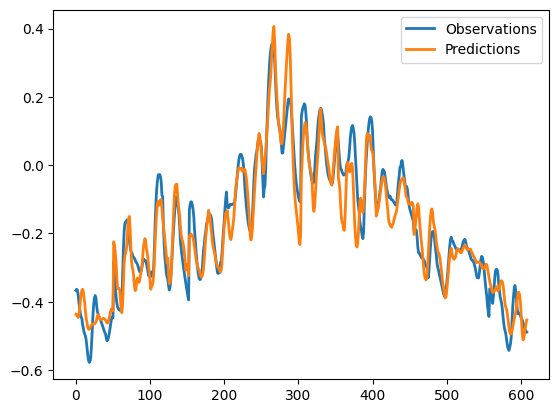

In [ ]:
plt.plot(labels_val_true, lw=2, label="Observations")
plt.plot(labels_val_pred, lw=2, label="Predictions")
plt.legend()

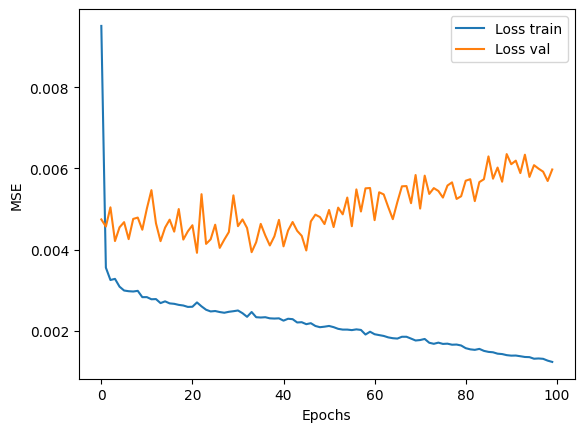

In [ ]:
# Plot loss history
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(history.history["loss"], label="Loss train")
plt.plot(history.history["val_loss"], label="Loss val")
plt.legend();